## Introduction

In this notebook, we perform image classification on the CIFAR-10 dataset using a feature extraction approach applied to a pre-trained Vision Transformer (ViT) model.
The Vision Transformer (ViT) is a deep learning model that applies transformer architectures to image classification tasks. Instead of using convolutional layers, ViT treats an image as a sequence of patches and processes it similarly to word tokens in NLP, allowing the model to capture long-range dependencies and global context more effectively.

For this project:
- We load a Vision Transformer (ViT) model pre-trained on the ImageNet dataset.
- We remove the original final classification head.
- We extract features from the frozen ViT.
- Initially, we considered using a pure linear probing approach (training only a single linear layer on top of the extracted features).
- However, to improve performance, we instead train a small two-layer neural network (MLP) with a hidden layer and dropout regularization on top of the ViT features.

Training is performed using PyTorch, and model performance is evaluated based on both training and validation accuracy.

---

### Reference

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N.  
*An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale.*  
International Conference on Learning Representations (ICLR), 2021.  


In [8]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Model Loading and Feature Extraction Setup

In this section, we prepare the pre-trained Vision Transformer (ViT-B/16) model for feature extraction and  load ViT-B/16 with weights trained on the ImageNet-1K dataset. All parameters of the ViT backbone are frozen to ensure that only the newly added classifier will be trained. The original classification head is replaced with an `nn.Identity()` layer. This allows the model to output high-dimensional feature vectors suitable for linear probing or training a new classifier.



In [9]:
# Load the pre-trained Vision Transformer (ViT-B/16) model with ImageNet-1K weights
weights = ViT_B_16_Weights.IMAGENET1K_V1
vit = vit_b_16(weights=weights)

# Freeze all parameters
for param in vit.parameters():
    param.requires_grad = False

# Replace the original classification head with an Identity layer
# This allows the model to output the extracted feature vectors instead of class scores
vit.heads = nn.Identity()

vit.eval()
vit.to(device);

## Data Loading and Preprocessing

In this section, we prepare the CIFAR-10 dataset for input into the Vision Transformer (ViT-B/16) model. Each image is resized from 32x32 pixels to 224x224 pixels to match the input size expected by ViT-B/16. Normalization is applied using the mean and standard deviation values from ImageNet.


In [10]:
# Transformation pipeline for the CIFAR-10 images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images from 32x32 to 224x224 (expected by ViT-B/16)
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
        std=[0.229, 0.224, 0.225]    # Normalize using ImageNet standard deviation
    )
])


trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 56.2MB/s]


## Feature Extraction for Linear Probing

To perform classification using a feature extraction approach with the Vision Transformer (ViT-B/16), both the training and test datasets are passed through the frozen ViT model. For each image batch, the model outputs a feature vector of size 768.


In [11]:
# Lists to store extracted training features and corresponding labels
train_features, train_labels = [], []

# Extract features from the training dataset using the frozen ViT model
with torch.no_grad():
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        features = vit(images)          # Feature output: [batch_size, 768]
        train_features.append(features.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

# Lists to store extracted test features and corresponding labels
test_features, test_labels = [], []

# Extract features from the test dataset using the frozen ViT model
with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        features = vit(images)          # Feature output: [batch_size, 768]
        test_features.append(features.cpu())
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 157/157 [02:09<00:00,  1.22it/s]


## Training a Two-Layer Neural Network on ViT Features

In this section, we train a small feed-forward neural network on top of the extracted feature representations from the Vision Transformer (ViT-B/16):

- **Classifier Architecture**:
  - A multilayer perceptron (MLP) with:
    - An input size of 768 (ViT feature dimension).
    - A hidden layer with 512 units and ReLU activation.
    - Dropout layers before and after the hidden layer for regularization.
    - A final output layer mapping to the 10 CIFAR-10 classes.

- **Training Setup**:
  - Optimizer: Adam with an initial learning rate of 5e-4 and weight decay of 1e-3 for regularization.
  - Learning rate scheduler: Exponential decay with a decay rate of 0.9 applied after each epoch.
  - Loss function: Cross-entropy loss for multi-class classification.



In [12]:
# Number of training epochs
epochs = 50

train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Define a simple classifier on top of the 768-dimensional ViT features
classifier = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 10)
).to(device)

# Define the optimizer and learning rate scheduler
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in trainloader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_acc.append(100 * correct / total)

    # Update learning rate
    scheduler.step()

    # Evaluation phase
    classifier.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

    # Calculate and store average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_acc.append(test_accuracy)

print("\n=== Final Results After Training ===")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")



=== Final Results After Training ===
Final Training Loss: 0.0663
Final Training Accuracy: 97.98%
Final Test Loss: 0.1139
Final Test Accuracy: 96.11%


## Conclusion

After training a small two-layer neural network on top of the extracted Vision Transformer (ViT-B/16) features for 50 epochs, the final results are summarized below:

| Metric                  | Value          |
|--------------------------|----------------|
| Final Training Loss      | 0.0663          |
| Final Training Accuracy  | 97.98%          |
| Final Test Loss          | 0.1139          |
| Final Test Accuracy      | 96.11%          |

By using a two-layer MLP on top of frozen ViT features, we achieved a **final test accuracy of 96.11%**, which is the highest among all models evaluated in this project.This experiment highlights the power of transformer-based architectures for image classification tasks, even with minimal fine-tuning.


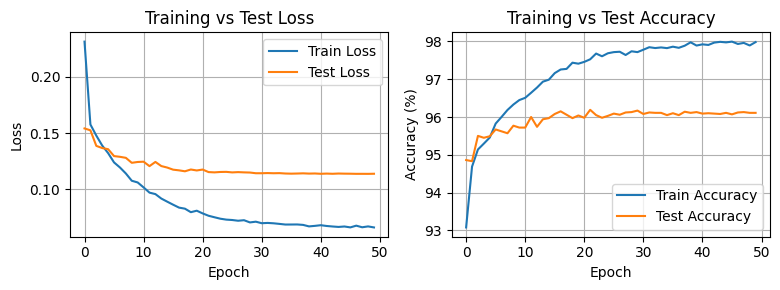

In [13]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
